**Importing Libraries**

 suppresses warning messages during code execution

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

**mounts Google Drive into the Colab**

****

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


This code lists the folders in the directory '/content/drive/MyDrive/brain tumor' and prints out their names.

In [ ]:
import os

dataset_path = '/content/drive/MyDrive/brain tumor'

folders = os.listdir(dataset_path)
print(folders)


['no', 'yes']


prints out the number of images

In [ ]:
subdirs = os.listdir(dataset_path)[:3]
for subdir in subdirs:
    print(f"{subdir} contains {len(os.listdir(dataset_path+'/'+subdir))} images")

no contains 64 images
yes contains 64 images


In [ ]:
def load_images(folder):

    imgs = []
    target = 0
    labels = []
    for i in os.listdir(folder):
        subdir = os.path.join(folder, i)
        for j in os.listdir(subdir):
            img_dir = os.path.join(subdir,j)
            try:
                img = cv2.imread(img_dir)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (128,128))
                imgs.append(img)
                labels.append(target)
            except:
                continue
        target += 1

    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels


In [ ]:
data, labels = load_images(dataset_path)
data.shape, labels.shape

((128, 128, 128), (128,))

**Visualizing images**

In [ ]:
def plot_images(start, end):
    plt.figure(figsize=(22,8))
    for i in range(10):
        axs = plt.subplot(2,5, i+1)
        idx = np.random.randint(start, end)
        plt.imshow(data[idx], cmap='gray')
        plt.axis('on')
        axs.set_xticklabels([])
        axs.set_yticklabels([])
        plt.subplots_adjust(wspace=None, hspace=None)

 images with   brain tumor

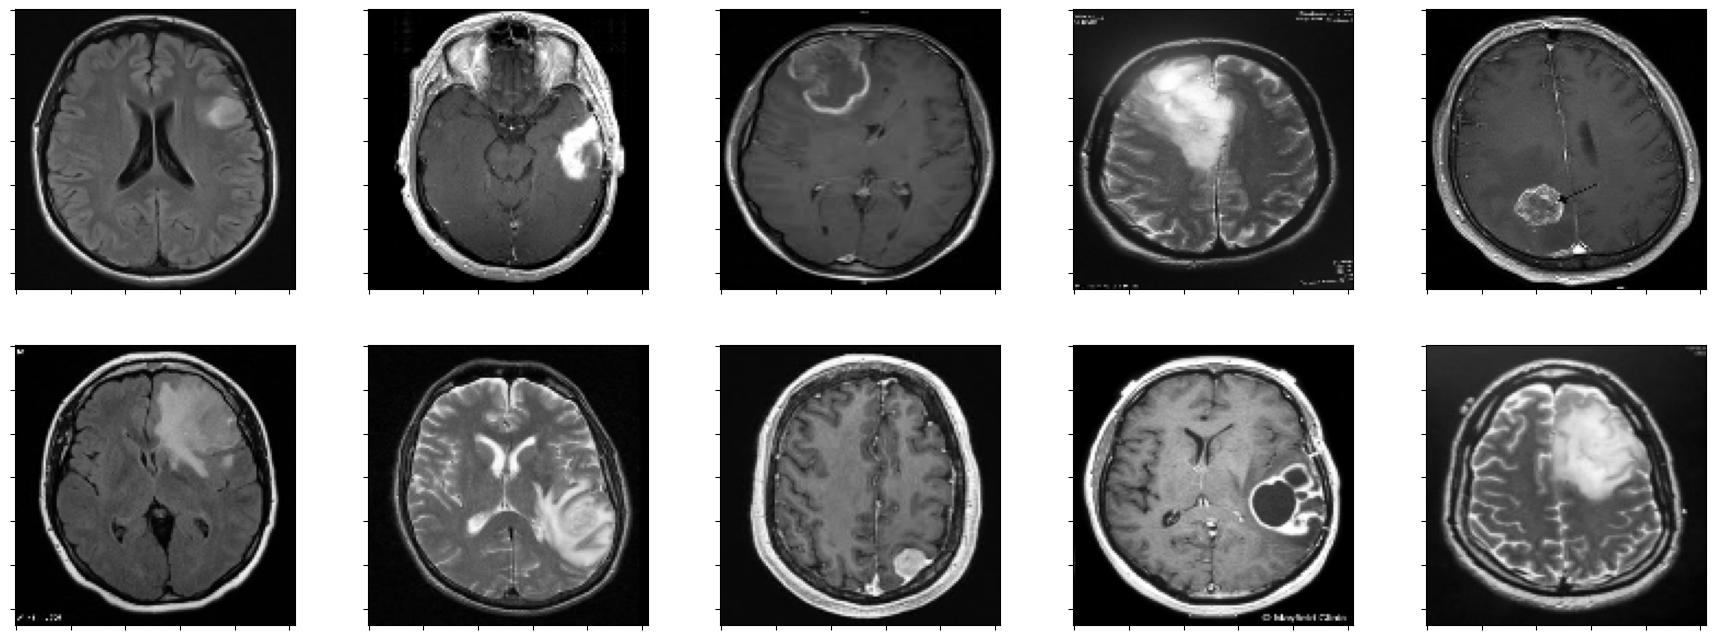

In [ ]:
plot_images(64,127)

 images with no brain tumor

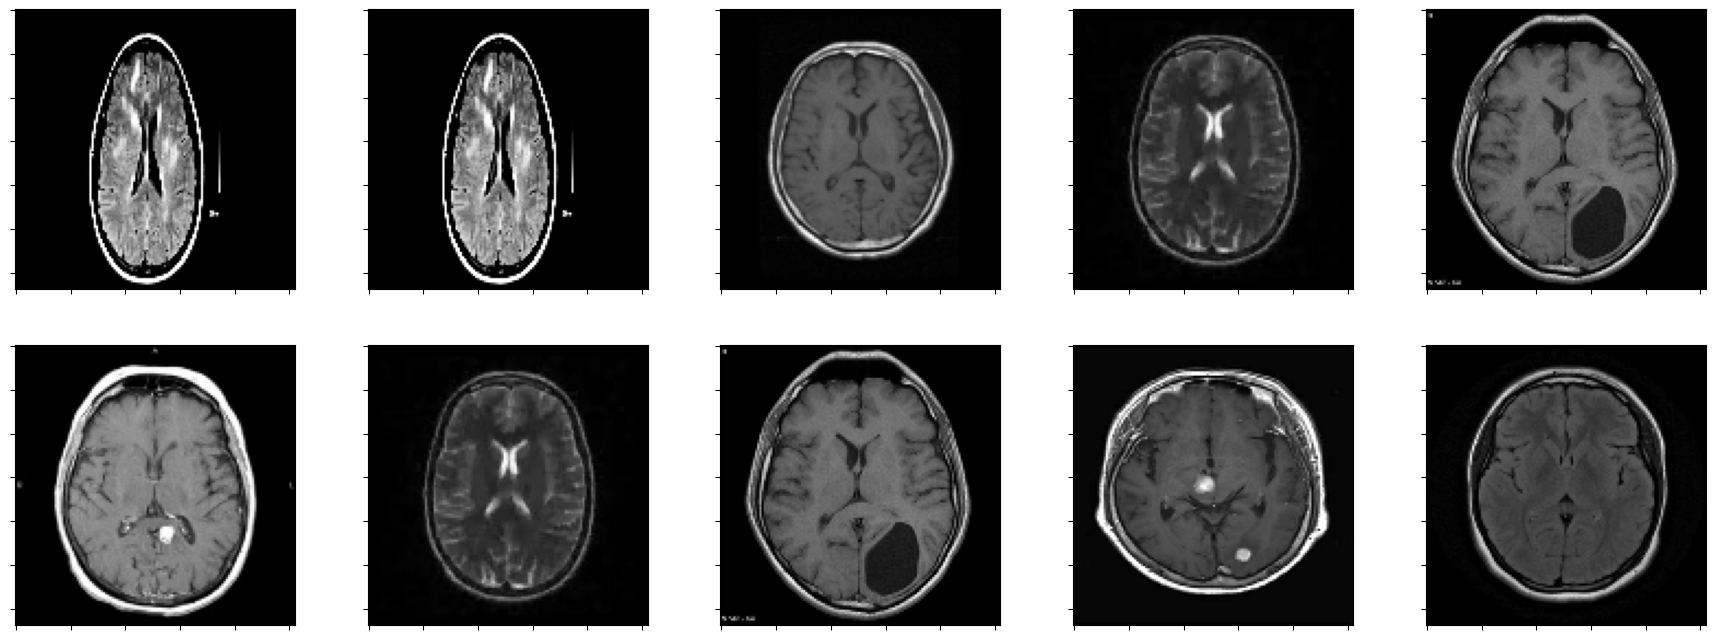

In [ ]:
plot_images(0,63)

**Normalization**

In [ ]:
norm_data = data /130
norm_data = np.expand_dims(norm_data, axis=3)
norm_data.shape, norm_data[0]

((128, 128, 128, 1),
 array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]))

**Convolutional Neural Network**

In [ ]:
SEED = 40

In [ ]:
tf.random.set_seed(SEED)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(128,128,1)),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.Conv2D(16,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

**compiling the model**

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

**fitting the model**

In [ ]:
history = model.fit(norm_data, labels, epochs = 10, validation_split = 0.20)

Epoch 1/10
4/4 [==============================] - 12s 2s/step - loss: 0.6737 - accuracy: 0.5686 - val_loss: 0.9771 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 10s 2s/step - loss: 0.5773 - accuracy: 0.6667 - val_loss: 1.0330 - val_accuracy: 0.4231
Epoch 3/10
4/4 [==============================] - 8s 2s/step - loss: 0.4766 - accuracy: 0.7745 - val_loss: 0.9840 - val_accuracy: 0.6538
Epoch 4/10
4/4 [==============================] - 10s 3s/step - loss: 0.4435 - accuracy: 0.7843 - val_loss: 0.5613 - val_accuracy: 0.7692
Epoch 5/10
4/4 [==============================] - 8s 2s/step - loss: 0.4295 - accuracy: 0.7843 - val_loss: 0.9498 - val_accuracy: 0.6538
Epoch 6/10
4/4 [==============================] - 10s 2s/step - loss: 0.3602 - accuracy: 0.8333 - val_loss: 0.8411 - val_accuracy: 0.7308
Epoch 7/10
4/4 [==============================] - 9s 2s/step - loss: 0.3232 - accuracy: 0.8235 - val_loss: 0.9967 - val_accuracy: 0.6923
Epoch 8/10
4/4 [=================

**Evaluation**

In [ ]:
result = model.evaluate(norm_data, labels, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 90.62%
Loss: 0.3108


this above result gives the evaluation on the training set only, now we will make predictions on randomly picked images from the training data and compare our results.

randomly generating 20 numbers to index from data

In [ ]:
np.random.seed(SEED)
indxs = np.random.randint(0, 128, 20)

In [ ]:
y_pred_prob = model.predict(norm_data[indxs])
y_pred = np.array([1 if prob>0.5 else 0 for prob in y_pred_prob])

y_true = labels[indxs]
y_pred.shape, y_true.shape

1/1 [==============================] - 1s 654ms/step


((20,), (20,))

In [ ]:
y_pred

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0])

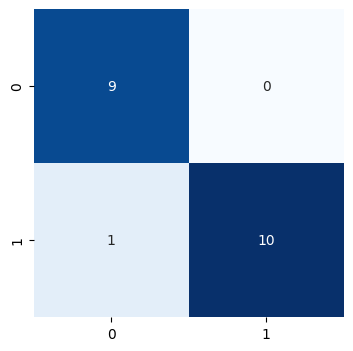

In [ ]:
plt.figure(figsize = (4,4))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap = "Blues", annot = True, fmt = ".2g", cbar = False)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.91      0.95        11

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 64)      640       
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 124, 32)      18464     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 conv2d_15 (Conv2D)          (None, 58, 58, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 29, 29, 16)        0         
 g2D)                                                 

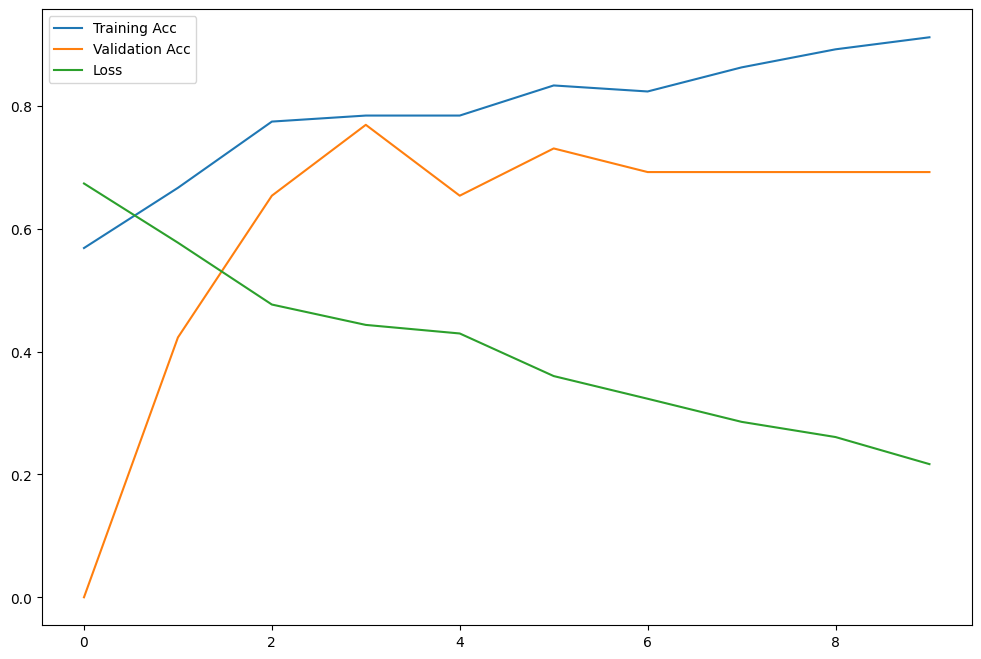

In [ ]:
histdf = pd.DataFrame(history.history)

plt.figure(figsize=(12,8))
plt.plot(histdf['accuracy'], label='Training Acc')
plt.plot(histdf['val_accuracy'], label='Validation Acc')
plt.plot(histdf['loss'], label='Loss')
plt.legend()
plt.show()

**Its performance on a separate test set**

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_path')

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input

# Define preprocessing function for multiple images
def preprocess_images(img_paths, target_size=(128, 128)):
    preprocessed_images = []
    for img_path in img_paths:
        img = image.load_img(img_path, target_size=target_size, color_mode="grayscale")
        img_array = image.img_to_array(img)
        img_array /= 255.
        img_array = np.expand_dims(img_array, axis=0)
        preprocessed_images.append(img_array)
    return np.vstack(preprocessed_images)

# Load trained model
model = load_model('model_path')

# Directory containing test images
test_dir = '/content/drive/MyDrive/test'
# List of test image paths
test_image_paths = [os.path.join(test_dir, img_name) for img_name in os.listdir(test_dir)]

# Preprocess test images
preprocessed_imgs = preprocess_images(test_image_paths)

# Make predictions
predictions = model.predict(preprocessed_imgs)

# Iterate over predictions and print results
for img_name, prediction in zip(os.listdir(test_dir), predictions):
    predicted_label = "Tumor" if prediction[0] > 0.5 else "No Tumor"
    print(f"Image: {img_name}, Predicted label: {predicted_label}")


2/2 [==============================] - 1s 264ms/step
Image: test (11).jpg, Predicted label: No Tumor
Image: test (1).jpeg, Predicted label: No Tumor
Image: test (1).JPG, Predicted label: Tumor
Image: test (12).jpg, Predicted label: No Tumor
Image: test (10).JPG, Predicted label: No Tumor
Image: test (23).jpg, Predicted label: Tumor
Image: test (18).jpg, Predicted label: No Tumor
Image: test (26).jpg, Predicted label: No Tumor
Image: test (21).jpg, Predicted label: No Tumor
Image: test (20).jpg, Predicted label: No Tumor
Image: test (17).jpg, Predicted label: No Tumor
Image: test (19).jpg, Predicted label: Tumor
Image: test (13).jpg, Predicted label: No Tumor
Image: test (22).jpg, Predicted label: No Tumor
Image: test (24).jpg, Predicted label: No Tumor
Image: test (16).jpg, Predicted label: No Tumor
Image: test (25).jpg, Predicted label: No Tumor
Image: test (2).JPG, Predicted label: Tumor
Image: test (15).jpg, Predicted label: Tumor
Image: test (14).jpg, Predicted label: No Tumor
Imag

In [ ]:
history = model.fit(norm_data, labels, epochs = 10, validation_split = 0.20)

Epoch 1/10
4/4 [==============================] - 15s 3s/step - loss: 0.2416 - accuracy: 0.9412 - val_loss: 0.6057 - val_accuracy: 0.8077
Epoch 2/10
4/4 [==============================] - 13s 4s/step - loss: 0.1573 - accuracy: 0.9412 - val_loss: 1.0213 - val_accuracy: 0.6538
Epoch 3/10
4/4 [==============================] - 8s 2s/step - loss: 0.1268 - accuracy: 0.9608 - val_loss: 1.0051 - val_accuracy: 0.6538
Epoch 4/10
4/4 [==============================] - 10s 2s/step - loss: 0.0879 - accuracy: 0.9706 - val_loss: 0.8318 - val_accuracy: 0.7692
Epoch 5/10
4/4 [==============================] - 9s 2s/step - loss: 0.0664 - accuracy: 0.9804 - val_loss: 1.1400 - val_accuracy: 0.6154
Epoch 6/10
4/4 [==============================] - 9s 2s/step - loss: 0.0460 - accuracy: 0.9804 - val_loss: 0.7808 - val_accuracy: 0.8077
Epoch 7/10
4/4 [==============================] - 10s 3s/step - loss: 0.0314 - accuracy: 1.0000 - val_loss: 1.1919 - val_accuracy: 0.6923
Epoch 8/10
4/4 [=====================

In [ ]:
result = model.evaluate(norm_data, labels, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 93.75%
Loss: 0.3341
